In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import soundfile
import librosa

Sample rate of the audio file:  8000


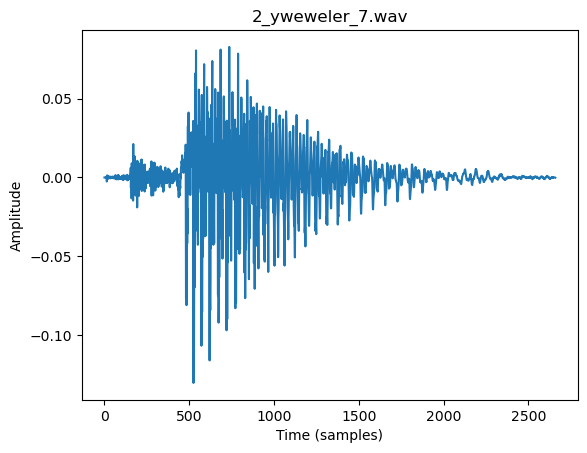

In [31]:
#folder_path = "data/audio/fold1"
folder_path = "data/audioMNIST/data"
# Get a list of all files in the folder_path
all_files = os.listdir(folder_path)

# Sample 3 files from the list
sample_file = np.random.choice(all_files, size=1, replace=False)

sr , _ = wavfile.read(folder_path + "/" + sample_file[0])
print("Sample rate of the audio file: ", sr)
y, sr = librosa.load(folder_path + "/" + sample_file[0], sr=sr)
plt.plot(y);
plt.title(sample_file[0]);
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');


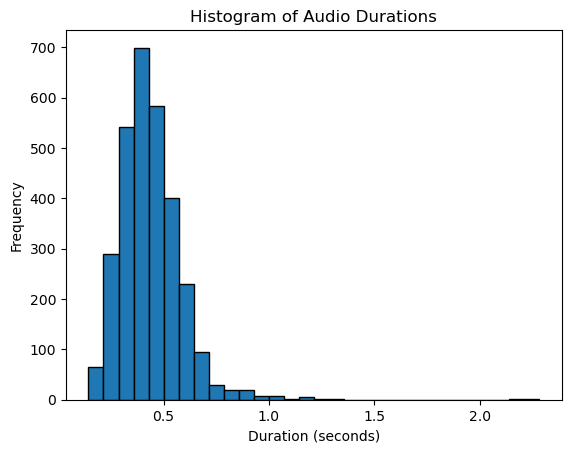

In [3]:
folder_path = "data/audioMNIST/data/"
        
durations = [len(librosa.load(folder_path+file, sr=sr)[0])/sr for file in all_files if file.endswith('.wav')]

plt.hist(durations, bins=30, edgecolor='black')
plt.title('Histogram of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [4]:
max_duration = np.argmax(durations)
min_duration = np.argmin(durations)
print('Longest audio file:', all_files[max_duration], 'Duration:', durations[max_duration], 'seconds')
print('Shortest audio file:', all_files[min_duration], 'Duration:', durations[min_duration], 'seconds')

Longest audio file: 9_theo_16.wav Duration: 2.28275 seconds
Shortest audio file: 6_yweweler_3.wav Duration: 0.1435 seconds


In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(durations, 1)
Q3 = np.percentile(durations, 99)
print('Q1:', Q1)
print('Q3:', Q3)

# Find the outliers
duration_outliers = [d for d in durations if d < Q1 or d > Q3]
np.size(duration_outliers)
print('Number of outliers:', np.size(duration_outliers))

Q1: 0.19262125
Q3: 0.9201599999999991
Number of outliers: 60


In [4]:
def pad_signal(S, max_length):
    dif_sample = abs(len(S) - max_length) # Calculate the differnce in desired signal length and the current signal length

    if len(y) % 2 != 0:
        padded_y = np.pad(S, (dif_sample//2, dif_sample//2 + 1), 'constant', constant_values=(0, 0))
    else:
        padded_y = np.pad(S, (dif_sample//2, dif_sample//2), 'constant', constant_values=(0, 0))

    return padded_y

In [32]:
padded_y = pad_signal(y, 8000)

In [33]:
padded_y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Text(0.5, 1.0, 'Spectrogram')

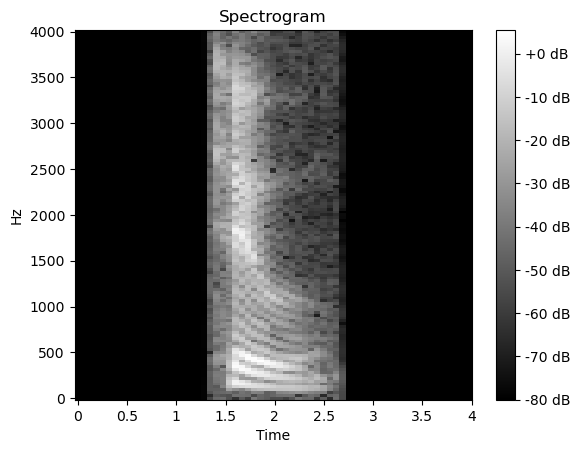

In [63]:
n_fft = 256
spec = np.abs(librosa.stft(padded_y, n_fft=n_fft, hop_length=n_fft//2))
epsilon = 1e-4
spec_db = np.array(20 * np.log10(spec + epsilon))
img = librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='linear', fmax = sr//2, fmin=0, cmap='grey')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

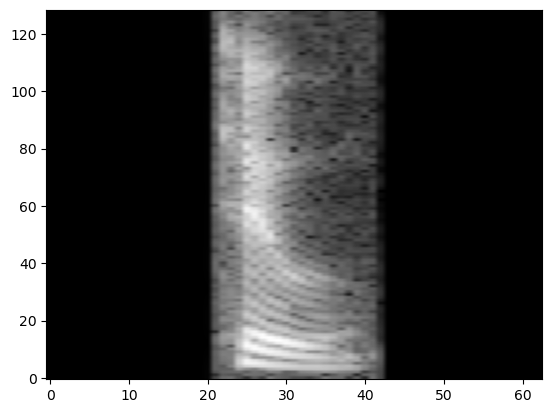

In [67]:
plt.imshow(spec_db, aspect='auto', origin='lower', cmap='gray')

In [62]:
5 // 2

2

In [41]:
file_name = sample_file[0].split('.')[0]
np.save(f'data/audioMNIST/data_spec/{file_name}.npy', spec_db)

#### Export all Spectrograms

In [48]:
def load_data(folder_path):
    # Get a list of all files in the folder_path
    all_files = os.listdir(folder_path)

    # Determine samplerate of signal
    sr , _ = wavfile.read(folder_path + "/" + all_files[0])

    audio_data = []
    # Load the audio files
    for file in all_files:
        if file.endswith('.wav'):
            y = librosa.load(folder_path + "/" + file, sr=sr)[0]
            audio_data.append((y,file))

    return audio_data

def gen_spectgrams(audio_data, n_fft=128):
    # Compute the mel spectrogram
    spects = []
    for audio in audio_data:
        padded_y = pad_signal(audio[0], 8000)
        spec = np.abs(librosa.stft(padded_y, n_fft=n_fft, hop_length=n_fft//2))
        epsilon = 1e-4
        spec_db = np.array(20 * np.log10(spec + epsilon))
        spects.append((spec_db, audio[1]))
    return spects

In [51]:
mnsit_data = load_data('data/audioMNIST/data')

results = gen_spectgrams(mnsit_data, n_fft = 256)

# Designated folder location to save the matrix files
output_folder = "data/audioMNIST/data_spec"
os.makedirs(output_folder, exist_ok=True)

# Iterate through the results and save each mel-spectrogram matrix as a .npy file
for mel_spect_db, file_name in results:
    output_path = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}.npy")
    np.save(output_path, mel_spect_db)

In [58]:
file_name = '0_george_5'

spec_db = np.load(f'data/audioMNIST/data_spec/{file_name}.npy')

amplitude_spec = np.array(10**(spec_db/20))

y_reconstructed = librosa.griffinlim(amplitude_spec, n_iter=64, hop_length=n_fft//2, n_fft=n_fft)




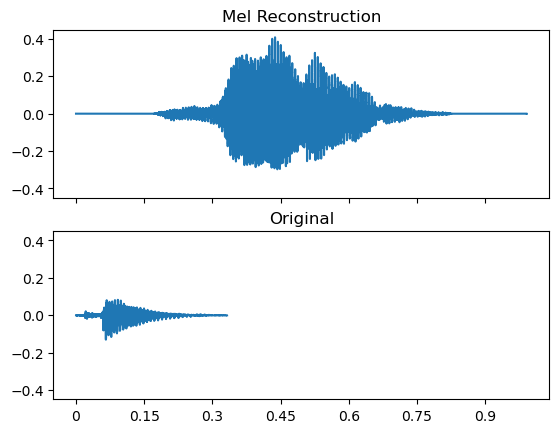

In [59]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

librosa.display.waveshow(y_reconstructed, sr=sr, ax=ax[0])
librosa.display.waveshow(y, sr=sr, ax=ax[1])
ax[0].set(title='Mel Reconstruction', xlabel=None)
ax[0].label_outer()
ax[1].set(title='Original', xlabel=None)
ax[1].label_outer()

In [60]:
import soundfile as sf

sf.write('output.wav', y_reconstructed, sr)